In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import py_wake
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap


from py_wake.wind_farm_models import All2AllIterative
from py_wake.wind_farm_models import PropagateDownwind
from py_wake.deficit_models.deficit_model import WakeDeficitModel, BlockageDeficitModel
from py_wake.deficit_models.no_wake import NoWakeDeficit
from py_wake.site._site import UniformSite
from py_wake.flow_map import XYGrid
from py_wake.flow_map import XZGrid
from py_wake.flow_map import YZGrid
from py_wake.turbulence_models import CrespoHernandez
from py_wake.turbulence_models import GCLTurbulence
from py_wake.deficit_models import Rathmann
from py_wake.utils.plotting import setup_plot

from py_wake.site import UniformWeibullSite

from py_wake.wind_turbines import WindTurbine, WindTurbines
from py_wake.wind_turbines.power_ct_functions import PowerCtTabular
from py_wake.wind_turbines.generic_wind_turbines import GenericWindTurbine

from py_wake.deficit_models import BastankhahGaussianDeficit
from py_wake.deficit_models.utils import ct2a_madsen

from scipy.optimize import differential_evolution
from scipy.optimize import dual_annealing
from scipy.optimize import brute


import h5py
import xarray as xr

import time

from tabulate import tabulate



In [2]:
#turbine parameters
D = 283.21 #rotor diameter
H=170 #hub height
Prated=22000 #kW

WD=270  #wind direction
WS=9 #wind speed
YD=0   #yaw direction
TI=0   #turbulence intensity


#site
site= UniformWeibullSite(p_wd=[0.03597152, 0.03948682, 0.05167394999999999, 0.07000154, 0.08364547,0.0643485,0.08643194,0.1177051,0.1515757, 0.14737920000000002, 0.1001205 , 0.1001205],  # sector frequencies
                               a=[9.176929, 9.782334, 9.531809,9.909545, 10.04269, 9.593921, 9.584007, 10.51499, 11.39895, 11.68746,11.63732,10.08803],          # Weibull scale parameter
                               k=[ 2.392578,2.447266,2.412109,2.591797, 2.755859, 2.595703, 2.583984,2.548828, 2.470703,2.607422, 2.626953, 2.326172],          # Weibull shape parameter
                               ti=TI                          # turbulence intensity, optional
                               )



from py_wake.wind_turbines.power_ct_functions import PowerCtTabular

#curves generated by openfast
u=[3,4.06,5,6.15,7.16,8.18,9.027,10.21,11.17,12.26,13.47,14.1,15.47]
ct=[0.88,0.8843,0.8828,0.887,0.8872,0.8899,0.89,0.8,0.58,0.406,0.2933,0.2518,0.1835]
power=[474,1176,2194,4094,6414,9562,12840,19310,22000,22000,22000,22000,22000]

windTurbines = WindTurbine(name='MyWT',
                    diameter=D,
                    hub_height=H,
                    powerCtFunction=PowerCtTabular(u,power,'kW',ct))

In [3]:
simulation_data_xy = np.loadtxt('101_IEA22MW_baseline_new_xy.txt') #put respective LES


In [4]:
def get_velocity_field_xy(model=None, grid=XYGrid(x=np.linspace(0, 4400, 440), y=np.linspace(-1400 ,1400, 280), h=H)):
    wfm = All2AllIterative(site, windTurbines, wake_deficitModel=model,blockage_deficitModel=Rathmann(), turbulenceModel=GCLTurbulence())
    result = wfm(x=[0], y=[0], wd=WD, ws=WS, yaw=YD).flow_map(grid)
    return result.WS_eff.values.squeeze()



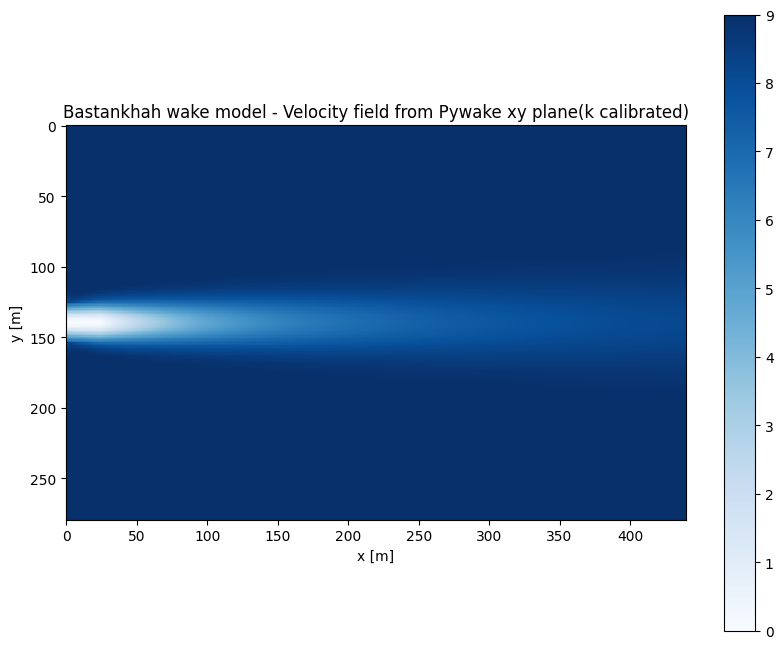

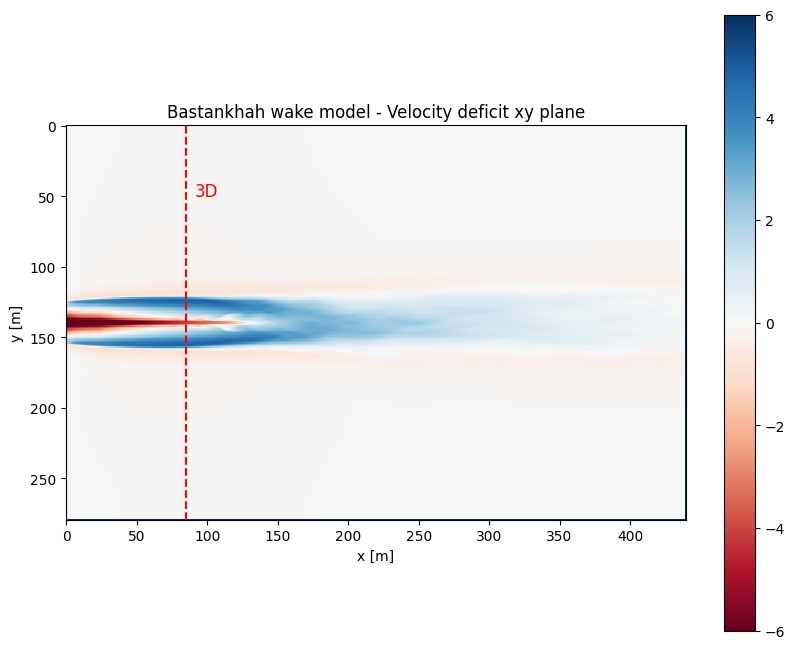

In [5]:
wf_model = BastankhahGaussianDeficit()

velocity_xy = get_velocity_field_xy(wf_model)


fig = plt.figure(figsize=(10, 8))
plt.imshow(velocity_xy, cmap='Blues', interpolation='nearest', vmin=0, vmax=9)
plt.colorbar()  
plt.title('Bastankhah wake model - Velocity field from Pywake xy plane(k calibrated)')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.show()



bias1_xy=velocity_xy-simulation_data_xy
fig = plt.figure(figsize=(10, 8))
plt.imshow(bias1_xy, cmap='RdBu', interpolation='nearest', vmin=-6, vmax=6)
plt.colorbar()  
plt.title('Bastankhah wake model - Velocity deficit xy plane')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.axvline(x=0.3*D, color='red', linestyle='--')
plt.text(0.35*D, 50, '3D', color='red', fontsize=12, ha='center')
plt.show()




differential evolution large set of boundaries + local refinement

In [6]:
#differential evolution large set of boundaries + local refinement

#XY 

def objective_function_DE5(params):
    k = params[0]  
    model_cal = BastankhahGaussianDeficit(k=k)
    velocity_calibr_array = get_velocity_field_xy(model_cal).ravel()
    result_DE5 = np.average(abs(velocity_calibr_array -simulation_data_xy.ravel()))

    return [result_DE5] * len(params)  

initial_params_DE5 =  None
bounds_DE5 = [(0 , 2)]
start_time_DE5=time.time()
result_DE5 = differential_evolution(objective_function_DE5, bounds_DE5, strategy='best1bin', maxiter=100, popsize=50, tol=0.000001, seed=42, x0=initial_params_DE5)
end_time_DE5=time.time()
time_DE5=end_time_DE5-start_time_DE5

print(f"Elapsed Time: {time_DE5} seconds")
termination_message = result_DE5.message
print(f"Termination message: {termination_message}")

optimized_params_DE5 = result_DE5.x[0]
optimal_function_DE5 = result_DE5.fun
print("Best Solution (k):", optimized_params_DE5)
print("Best Objective Value:", optimal_function_DE5)

wf_model_optimized_DE5=BastankhahGaussianDeficit(ct2a=ct2a_madsen, k=optimized_params_DE5)
velocity_final_DE5=get_velocity_field_xy(wf_model_optimized_DE5)


#local refinement
from scipy.optimize import least_squares

def objective_function_LS(params):
    k = params[0]  
    model_cal = BastankhahGaussianDeficit(k=k)
    velocity_calibr_array = get_velocity_field_xy(model_cal).ravel()
    result_DE5 = np.sum(abs(velocity_calibr_array -simulation_data_xy.ravel()))

    return [result_DE5] * len(params)  

result_refinement_DE5= least_squares(objective_function_LS, x0=optimized_params_DE5)
optimized_params_DE5_refined=result_refinement_DE5.x
np.set_printoptions(precision=16)
print("Best parameter refined:", optimized_params_DE5_refined)
print("Best Objective function refined:", result_refinement_DE5.fun)


#optimal bounds -  depending on the best among montecarlo or least squares
best_bounds_min_k= optimized_params_DE5_refined-0.2 * abs(optimized_params_DE5_refined)
best_bounds_max_k= optimized_params_DE5_refined+0.2 * abs(optimized_params_DE5_refined)
    

best_bounds_xy=[(best_bounds_min_k[0],best_bounds_max_k[0])]
array = np.array(best_bounds_xy)
np.savetxt('bastan_best_bounds_101_IEA22MW_baseline_new_xy.txt', array.flatten())
np.savetxt('bastan_best_params_101_IEA22MW_baseline_new_xy.txt', optimized_params_DE5_refined)



Elapsed Time: 43.455055952072144 seconds
Termination message: Optimization terminated successfully.
Best Solution (k): 0.016276163325841475
Best Objective Value: 0.2804008022566768
Best parameter refined: [0.0162762098923183]
Best Objective function refined: [34545.37883801473]


In [7]:
#XY
def objective_function_DE_xy(params):
    k = params[0]  
    model_cal = BastankhahGaussianDeficit(k=k)
    velocity_calibr_array = get_velocity_field_xy(model_cal).ravel()
    result_DE = np.average(abs(velocity_calibr_array -simulation_data_xy.ravel()))

    return [result_DE] * len(params)  

initial_params_DE = None
bounds = np.loadtxt('bastan_best_bounds_101_IEA22MW_baseline_new_xy.txt')
bounds_DE = [(bounds[0], bounds[1])]
start_time_DE = time.time()
result_DE = differential_evolution(objective_function_DE_xy, bounds_DE, strategy='best1bin', maxiter=300, popsize=50, tol=0.000001, seed=42, x0=initial_params_DE)
end_time_DE = time.time()
time_DE = end_time_DE - start_time_DE

print(f"Elapsed Time: {time_DE} seconds")
termination_message = result_DE.message
print(f"Termination message: {termination_message}")

optimized_params_DE_xy = result_DE.x[0]
optimal_function_DE_xy = result_DE.fun
print("Best Solution (k):", optimized_params_DE_xy)
print("Best Objective Value:", optimal_function_DE_xy)
np.savetxt('bastan_best_params_101_IEA22MW_baseline_new_xy.txt', np.array([optimized_params_DE_xy]))
optimal_function_array_xy = np.array([ optimal_function_DE_xy])
np.savetxt('bastan_best_sol_101_IEA22MW_baseline_new_xy.txt', optimal_function_array_xy)



Elapsed Time: 18.840786457061768 seconds
Termination message: Optimization terminated successfully.
Best Solution (k): 0.01627578008477717
Best Objective Value: 0.28040080226837183


In [ ]:
wf_model = BastankhahGaussianDeficit(k=optimized_params_DE_xy)

velocity_xy = get_velocity_field_xy(wf_model)


fig = plt.figure(figsize=(10, 8))
plt.imshow(velocity_xy, cmap='Blues', interpolation='nearest', vmin=0, vmax=9)
plt.colorbar()  
plt.title('Bastankhah wake model - Velocity field from Pywake xy plane ')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.axvline(x=0.3*D, color='red', linestyle='--')
plt.text(0.35*D, 50, '3D', color='red', fontsize=12, ha='center')
plt.show()



bias1_xy=velocity_xy-simulation_data_xy
fig = plt.figure(figsize=(10, 8))
plt.imshow(bias1_xy, cmap='RdBu', interpolation='nearest', vmin=-6, vmax=6)
plt.colorbar()  
plt.title('Bastankhah wake model - Velocity deficit xy plane')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.axvline(x=0.3*D, color='red', linestyle='--')
plt.text(0.35*D, 50, '3D', color='red', fontsize=12, ha='center')
plt.show()


In [9]:
#montecarlo analysis as local refinement
'''NN=1000
stv=0.2
possible_k=np.random.normal(0, stv, NN) * optimized_params_DE5 + optimized_params_DE5
best_function=10**16

def objective_function_DE5(params):
    k = params 

    
    model_cal = BastankhahGaussianDeficit(k=k)
    velocity_calibr_array = get_velocity_field(model_cal).ravel()
    result_DE5 = np.average(abs(velocity_calibr_array -simulation_data.ravel()))

    return result_DE5

for i in range (len(possible_k)):
    params=possible_k[i]
    error= objective_function_DE5(params)
    if error < best_function:
        best_function=error
        best_params_MC=params

print("Best parameter MC:", best_params_MC)
print("Best Objective function MC:", best_function)'''

'NN=1000\nstv=0.2\npossible_k=np.random.normal(0, stv, NN) * optimized_params_DE5 + optimized_params_DE5\nbest_function=10**16\n\ndef objective_function_DE5(params):\n    k = params \n\n    \n    model_cal = BastankhahGaussianDeficit(k=k)\n    velocity_calibr_array = get_velocity_field(model_cal).ravel()\n    result_DE5 = np.average(abs(velocity_calibr_array -simulation_data.ravel()))\n\n    return result_DE5\n\nfor i in range (len(possible_k)):\n    params=possible_k[i]\n    error= objective_function_DE5(params)\n    if error < best_function:\n        best_function=error\n        best_params_MC=params\n\nprint("Best parameter MC:", best_params_MC)\nprint("Best Objective function MC:", best_function)'

differential evolution trying different objective functions

In [10]:
#trying different objective functions
bounds_xy= np.loadtxt('bastan_best_bounds_101_IEA22MW_baseline_new_xy.txt')

#XY
best_bounds_xy=[(bounds_xy[0],bounds_xy[1])]
def objective_function_DE3_xy(params):
    k = params[0]     
    model_cal = BastankhahGaussianDeficit(k=k)
    velocity_calibr_array = get_velocity_field_xy(model_cal).ravel()

    tot = np.sum((velocity_calibr_array.ravel() - simulation_data_xy.ravel()) ** 2)
    result_DE3 = np.sqrt(tot / len(velocity_calibr_array))

    return [result_DE3] * len(params)  

initial_params_DE3 =  None
bounds_DE3 =best_bounds_xy
start_time_DE3=time.time()
result_DE3 = differential_evolution(objective_function_DE3_xy, bounds_DE3, strategy='best1bin', maxiter=300, popsize=50, tol=0.000001, seed=42, x0=initial_params_DE3)
end_time_DE3=time.time()
time_DE3=end_time_DE3-start_time_DE3
print(f"Elapsed Time: {time_DE3} seconds")
termination_message = result_DE3.message
print(f"Termination message: {termination_message}")

optimized_params_DE3_xy = result_DE3.x[0]
optimal_function_DE3_xy = result_DE3.fun
print("Best Solution (k):", optimized_params_DE3_xy)
print("Best Objective Value:", optimal_function_DE3_xy)

optimized_params_DE3arr = np.array([ optimized_params_DE3_xy])
np.savetxt('bastan_best_params_101_IEA22MW_baseline_new_xy_DE3.txt', optimized_params_DE3arr)
optimal_function_DE3arr = np.array([ optimal_function_DE3_xy])
np.savetxt('bastan_best_sol_101_IEA22MW_baseline_new_xy_DE3.txt', optimal_function_DE3arr)


#comparing results with RMSE objective function
wf_model_optimized_DE3=BastankhahGaussianDeficit(ct2a=ct2a_madsen, k=optimized_params_DE3_xy)
velocity_final_DE3=get_velocity_field_xy(wf_model_optimized_DE3)
result_DE5 = np.average(abs(velocity_final_DE3.ravel() -simulation_data_xy.ravel()))
np.savetxt('bastan_best_sol_101_IEA22MW_baseline_new_xy_DE3_ifRMSE.txt', np.array([result_DE5]))
print("If implemented with RMSE the objectie function would be:",result_DE5)






Elapsed Time: 16.043002128601074 seconds
Termination message: Optimization terminated successfully.
Best Solution (k): 0.017874237263944808
Best Objective Value: 0.9988868639487759
If implemented with RMSE the objectie function would be: 0.2820849614565224


simulated annealing

In [11]:
#simulated annealing
bounds_xy= np.loadtxt('bastan_best_bounds_101_IEA22MW_baseline_new_xy.txt')

#XY
best_bounds_xy=[(bounds_xy[0],bounds_xy[1])]
def objective_function_SA_xy(params):
    k = params[0]  
    model_cal = BastankhahGaussianDeficit(k=k)
    velocity_calibr_array = get_velocity_field_xy(model_cal).ravel()
    result_SA = np.average(abs(velocity_calibr_array -simulation_data_xy.ravel()))

    return result_SA

initial_params_SA = None
bounds_SA = best_bounds_xy
start_time_SA=time.time()
result_ann = dual_annealing(objective_function_SA_xy, bounds_SA ,maxiter=300,seed=42,x0=initial_params_SA)
end_time_SA=time.time()
time_SA=end_time_SA-start_time_SA
print(f"Elapsed Time: {time_SA} seconds")

optimized_params_simulatedann_xy = result_ann.x[0]
optimal_function_simulatedann_xy = result_ann.fun
print("Best Solution (k):", optimized_params_simulatedann_xy)
print("Best Objective Value:", optimal_function_simulatedann_xy)








Elapsed Time: 27.9973304271698 seconds
Best Solution (k): 0.016276426177830355
Best Objective Value: 0.2804008022601721


genetic algorithm

In [12]:
#genetic algorithm

from sko.GA import GA
bounds_xy= np.loadtxt('bastan_best_bounds_101_IEA22MW_baseline_new_xy.txt')


#XY
def objective_function_GA_xy(params):
    k = params[0]
    model_cal = BastankhahGaussianDeficit(k=k)
    velocity_calibr_array = get_velocity_field_xy(model_cal).ravel()
    result = np.average(abs(velocity_calibr_array -simulation_data_xy.ravel()))

    return result

start_time_GA=time.time()
ga = GA(func=objective_function_GA_xy, n_dim=1, size_pop=16, max_iter=300, prob_mut=0.001, lb=[bounds_xy[0]], ub=[bounds_xy[1]], precision=1e-6)
best_x_xy, best_y_xy = ga.run()
end_time_GA=time.time()
time_GA=end_time_GA-start_time_GA
print(f"Elapsed Time: {time_GA} seconds")
print('best_x:', best_x_xy, '\n', 'best_y:', best_y_xy)  





Elapsed Time: 286.2593126296997 seconds
best_x: [0.0164212670675276] 
 best_y: [0.2804156985218669]


grid search

Elapsed Time: 62.01877737045288 seconds
0.016272951391839333 0.28040080552576047


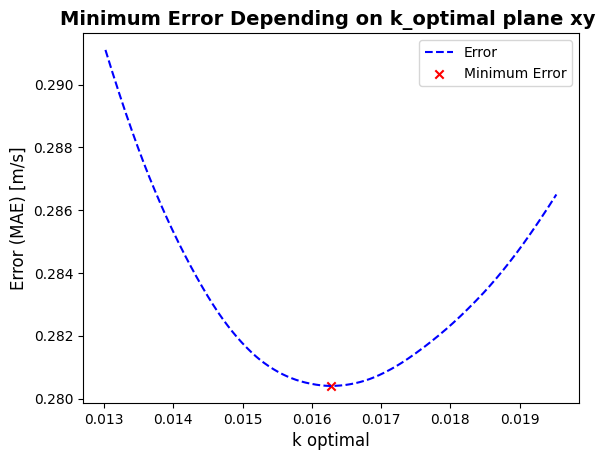

In [6]:
#done manually
bounds_xy= np.loadtxt('bastan_best_bounds_101_IEA22MW_baseline_new_xy.txt')


#XY
def objective_function_GS_xy(params):

    k = params
    model_cal = BastankhahGaussianDeficit(k=k)
    velocity_calibr_array = get_velocity_field_xy(model_cal).ravel()
    result_GS = np.average(abs(velocity_calibr_array -simulation_data_xy.ravel()))

    return result_GS

start_time_GS=time.time()
k_input_xy=np.linspace(bounds_xy[0] , bounds_xy[1], 1000)

error_xy=np.zeros(len(k_input_xy))
for i in range(0, len(k_input_xy) ):
    k_current=k_input_xy[i]
    
    error_xy[i]=objective_function_GS_xy(params=k_current)


optimal_function_gridsearch2_xy = np.min(error_xy)
min_index_xy = np.argmin(error_xy)
optimized_params_gridsearch2_xy= k_input_xy[min_index_xy]

end_time_GS=time.time()
time_GS=end_time_GS-start_time_GS
print(f"Elapsed Time: {time_GS} seconds")

print(optimized_params_gridsearch2_xy, optimal_function_gridsearch2_xy)


plt.plot(k_input_xy, error_xy,  linestyle='--', color='b', label='Error')
plt.scatter(optimized_params_gridsearch2_xy,optimal_function_gridsearch2_xy, color='red', label='Minimum Error', marker='x')
plt.xlabel('k optimal', fontsize=12)
plt.ylabel('Error (MAE) [m/s]', fontsize=12)
plt.title('Minimum Error Depending on k_optimal plane xy ', fontsize=14, fontweight='bold')
plt.legend()
plt.show()




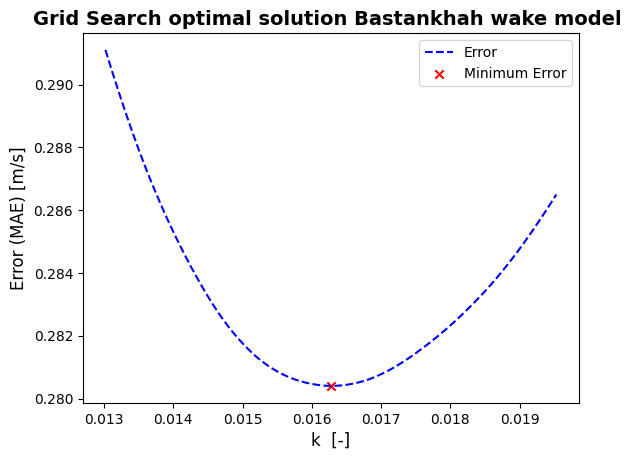

In [9]:
plt.plot(k_input_xy, error_xy,  linestyle='--', color='b', label='Error')
plt.scatter(optimized_params_gridsearch2_xy,optimal_function_gridsearch2_xy, color='red', label='Minimum Error', marker='x')
plt.xlabel('k  [-]', fontsize=12)
plt.ylabel('Error (MAE) [m/s]', fontsize=12)
plt.title('Grid Search optimal solution Bastankhah wake model ', fontsize=14, fontweight='bold')
plt.legend()
plt.show()


Analysis optimization hyperparameters

In [14]:
#seed

'''bounds= np.loadtxt('bastan_best_bounds_007sim.txt')
SS=[12,32,42]
def objective_function_DE(params):
    k = params[0]  
    model_cal = BastankhahGaussianDeficit(k=k)
    velocity_calibr_array = get_velocity_field(model_cal).ravel()
    tot = np.sum((velocity_calibr_array - simulation_data.ravel()) ** 2)
    result = np.sqrt(tot / len(velocity_calibr_array))
    return [result] * len(params)  

initial_params_DE =  None
bounds_DE = [(bounds[0],bounds[1])]

optimized_params_DE=np.zeros((len(SS), 1))
optimal_function_DE=np.zeros((len(SS), 1))
result_DE=np.zeros((len(SS), 1))

for i in range (len(SS)):
    result_DE = differential_evolution(objective_function_DE, bounds_DE, strategy='best1bin', maxiter=1000, popsize=15, tol=0.000001, seed=SS[i], x0=initial_params_DE)
    optimized_params_DE[i] = result_DE.x[0]
    optimal_function_DE[i] = result_DE.fun

np.set_printoptions(precision=16)
print("Best Solution (k):", optimized_params_DE)
print("Best Objective Value:", optimal_function_DE)


seed_legend = [f'Seed {seed}' for seed in SS]

plt.figure(figsize=(8, 6))  
for i in range(len(SS)):
    plt.scatter(optimized_params_DE[i], optimal_function_DE[i], marker='o', label=seed_legend[i])
plt.title('Error vs. k')
plt.xlabel('k')
plt.ylabel('Error')
plt.grid(True)
plt.legend()
plt.show()'''


'bounds= np.loadtxt(\'bastan_best_bounds_007sim.txt\')\nSS=[12,32,42]\ndef objective_function_DE(params):\n    k = params[0]  \n    model_cal = BastankhahGaussianDeficit(k=k)\n    velocity_calibr_array = get_velocity_field(model_cal).ravel()\n    tot = np.sum((velocity_calibr_array - simulation_data.ravel()) ** 2)\n    result = np.sqrt(tot / len(velocity_calibr_array))\n    return [result] * len(params)  \n\ninitial_params_DE =  None\nbounds_DE = [(bounds[0],bounds[1])]\n\noptimized_params_DE=np.zeros((len(SS), 1))\noptimal_function_DE=np.zeros((len(SS), 1))\nresult_DE=np.zeros((len(SS), 1))\n\nfor i in range (len(SS)):\n    result_DE = differential_evolution(objective_function_DE, bounds_DE, strategy=\'best1bin\', maxiter=1000, popsize=15, tol=0.000001, seed=SS[i], x0=initial_params_DE)\n    optimized_params_DE[i] = result_DE.x[0]\n    optimal_function_DE[i] = result_DE.fun\n\nnp.set_printoptions(precision=16)\nprint("Best Solution (k):", optimized_params_DE)\nprint("Best Objective Va

In [15]:
#max iter
'''bounds= np.loadtxt('bastan_best_bounds_007sim.txt')
mi=[5,7,10]
def objective_function_DE(params):
    k = params[0]  
    model_cal = BastankhahGaussianDeficit(k=k)
    velocity_calibr_array = get_velocity_field(model_cal).ravel()
    tot = np.sum((velocity_calibr_array - simulation_data.ravel()) ** 2)
    result_DE = np.sqrt(tot / len(velocity_calibr_array))
    return [result_DE] * len(params)  

initial_params_DE =  None
bounds_DE = [(bounds[0],bounds[1])]

optimized_params_DE=np.zeros((len(mi), 1))
optimal_function_DE=np.zeros((len(mi), 1))
result_DE=np.zeros((len(mi), 1))

for i in range (len(mi)):
    result_DE = differential_evolution(objective_function_DE, bounds_DE, strategy='best1bin', maxiter=mi[i], popsize=15, tol=0.000001, seed=42, x0=initial_params_DE)
    optimized_params_DE[i] = result_DE.x[0]
    optimal_function_DE[i] = result_DE.fun

np.set_printoptions(precision=16)
print("Best Solution (k):", optimized_params_DE)
print("Best Objective Value:", optimal_function_DE)

max_iter_legend = [f'Max Iter: {iter}' for iter in mi]

plt.figure(figsize=(8, 6))  
for i in range(len(mi)):
    plt.scatter(optimized_params_DE[i], optimal_function_DE[i], marker='o', label=max_iter_legend[i])
plt.title('Error vs. k')
plt.xlabel('k')
plt.ylabel('Error')
plt.grid(True)
plt.legend()
plt.show()'''

'bounds= np.loadtxt(\'bastan_best_bounds_007sim.txt\')\nmi=[5,7,10]\ndef objective_function_DE(params):\n    k = params[0]  \n    model_cal = BastankhahGaussianDeficit(k=k)\n    velocity_calibr_array = get_velocity_field(model_cal).ravel()\n    tot = np.sum((velocity_calibr_array - simulation_data.ravel()) ** 2)\n    result_DE = np.sqrt(tot / len(velocity_calibr_array))\n    return [result_DE] * len(params)  \n\ninitial_params_DE =  None\nbounds_DE = [(bounds[0],bounds[1])]\n\noptimized_params_DE=np.zeros((len(mi), 1))\noptimal_function_DE=np.zeros((len(mi), 1))\nresult_DE=np.zeros((len(mi), 1))\n\nfor i in range (len(mi)):\n    result_DE = differential_evolution(objective_function_DE, bounds_DE, strategy=\'best1bin\', maxiter=mi[i], popsize=15, tol=0.000001, seed=42, x0=initial_params_DE)\n    optimized_params_DE[i] = result_DE.x[0]\n    optimal_function_DE[i] = result_DE.fun\n\nnp.set_printoptions(precision=16)\nprint("Best Solution (k):", optimized_params_DE)\nprint("Best Objective 

In [16]:
#pop size

'''bounds= np.loadtxt('bastan_best_bounds_007sim.txt')
popS=[100,500,1000]
def objective_function_DE(params):
    k = params[0]  
    model_cal = BastankhahGaussianDeficit(k=k)
    velocity_calibr_array = get_velocity_field(model_cal).ravel()
    tot = np.sum((velocity_calibr_array - simulation_data.ravel()) ** 2)
    result_DE = np.sqrt(tot / len(velocity_calibr_array))
    return [result_DE] * len(params)  

initial_params_DE =  None
bounds_DE = [(bounds[0],bounds[1])]

optimized_params_DE=np.zeros((len(popS), 1))
optimal_function_DE=np.zeros((len(popS), 1))
result_DE=np.zeros((len(popS), 1))

for i in range (len(popS)):
    result_DE = differential_evolution(objective_function_DE, bounds_DE, strategy='best1bin', maxiter=15, popsize=popS[i], tol=0.000001, seed=42, x0=initial_params_DE)
    optimized_params_DE[i] = result_DE.x[0]
    optimal_function_DE[i] = result_DE.fun

np.set_printoptions(precision=16)
print("Best Solution (k):", optimized_params_DE)
print("Best Objective Value:", optimal_function_DE)

pop_size_legend = [f'Pop Size: {size}' for size in popS]

plt.figure(figsize=(8, 6))  
for i in range(len(popS)):
    plt.scatter(optimized_params_DE[i], optimal_function_DE[i], marker='o', label=pop_size_legend[i])
plt.title('Error vs. k')
plt.xlabel('k')
plt.ylabel('Error')
plt.grid(True)
plt.legend()
plt.show()'''

'bounds= np.loadtxt(\'bastan_best_bounds_007sim.txt\')\npopS=[100,500,1000]\ndef objective_function_DE(params):\n    k = params[0]  \n    model_cal = BastankhahGaussianDeficit(k=k)\n    velocity_calibr_array = get_velocity_field(model_cal).ravel()\n    tot = np.sum((velocity_calibr_array - simulation_data.ravel()) ** 2)\n    result_DE = np.sqrt(tot / len(velocity_calibr_array))\n    return [result_DE] * len(params)  \n\ninitial_params_DE =  None\nbounds_DE = [(bounds[0],bounds[1])]\n\noptimized_params_DE=np.zeros((len(popS), 1))\noptimal_function_DE=np.zeros((len(popS), 1))\nresult_DE=np.zeros((len(popS), 1))\n\nfor i in range (len(popS)):\n    result_DE = differential_evolution(objective_function_DE, bounds_DE, strategy=\'best1bin\', maxiter=15, popsize=popS[i], tol=0.000001, seed=42, x0=initial_params_DE)\n    optimized_params_DE[i] = result_DE.x[0]\n    optimal_function_DE[i] = result_DE.fun\n\nnp.set_printoptions(precision=16)\nprint("Best Solution (k):", optimized_params_DE)\nprin

In [17]:
#pop size

'''bounds= np.loadtxt('bastan_best_bounds_007sim.txt')
N=1
s1=np.ceil(10+2* np.sqrt(N))
s2= np.ceil(np.log(1-0.5**(1/N))/np.log(1-0.17))
popS=[s1,s2]
def objective_function_DE1(params):
    k = params[0]  
    model_cal = BastankhahGaussianDeficit(k=k)
    velocity_calibr_array = get_velocity_field(model_cal).ravel()
    tot = np.sum((velocity_calibr_array - simulation_data.ravel()) ** 2)
    result_DE1 = np.sqrt(tot / len(velocity_calibr_array))
    return [result_DE1] * len(params)  

initial_params_DE1 =  None
bounds_DE1 = [(bounds[0],bounds[1])]

optimized_params_DE1=np.zeros((len(popS), 1))
optimal_function_DE1=np.zeros((len(popS), 1))
result_DE1=np.zeros((len(popS), 1))

for i in range (len(popS)):
    result_DE1 = differential_evolution(objective_function_DE1, bounds_DE1, strategy='best1bin', maxiter=100, popsize=int(popS[i]), tol=0.000001, seed=42, x0=initial_params_DE1)
    optimized_params_DE1[i] = result_DE1.x[0]
    optimal_function_DE1[i] = result_DE1.fun

np.set_printoptions(precision=16)
print("Best Solution (k):", optimized_params_DE1)
print("Best Objective Value:", optimal_function_DE1)

pop_size_legend = [f'Pop Size: {size}' for size in popS]

plt.figure(figsize=(8, 6))  
for i in range(len(popS)):
    plt.scatter(optimized_params_DE1[i], optimal_function_DE1[i], marker='o', label=pop_size_legend[i])
plt.title('Error vs. k')
plt.xlabel('k')
plt.ylabel('Error')
plt.grid(True)
plt.legend()
plt.show()'''

'bounds= np.loadtxt(\'bastan_best_bounds_007sim.txt\')\nN=1\ns1=np.ceil(10+2* np.sqrt(N))\ns2= np.ceil(np.log(1-0.5**(1/N))/np.log(1-0.17))\npopS=[s1,s2]\ndef objective_function_DE1(params):\n    k = params[0]  \n    model_cal = BastankhahGaussianDeficit(k=k)\n    velocity_calibr_array = get_velocity_field(model_cal).ravel()\n    tot = np.sum((velocity_calibr_array - simulation_data.ravel()) ** 2)\n    result_DE1 = np.sqrt(tot / len(velocity_calibr_array))\n    return [result_DE1] * len(params)  \n\ninitial_params_DE1 =  None\nbounds_DE1 = [(bounds[0],bounds[1])]\n\noptimized_params_DE1=np.zeros((len(popS), 1))\noptimal_function_DE1=np.zeros((len(popS), 1))\nresult_DE1=np.zeros((len(popS), 1))\n\nfor i in range (len(popS)):\n    result_DE1 = differential_evolution(objective_function_DE1, bounds_DE1, strategy=\'best1bin\', maxiter=100, popsize=int(popS[i]), tol=0.000001, seed=42, x0=initial_params_DE1)\n    optimized_params_DE1[i] = result_DE1.x[0]\n    optimal_function_DE1[i] = result_

In [18]:
#tolerance

'''bounds= np.loadtxt('bastan_best_bounds_007sim.txt')
tol=[0.00000001,0.000000001,0.0000000001]
def objective_function_DE(params):
    k = params[0]  
    model_cal = BastankhahGaussianDeficit(k=k)
    velocity_calibr_array = get_velocity_field(model_cal).ravel()
    tot = np.sum((velocity_calibr_array - simulation_data.ravel()) ** 2)
    result_DE = np.sqrt(tot / len(velocity_calibr_array))
    return [result_DE] * len(params)  

initial_params_DE =  None


optimized_params_DE=np.zeros((len(tol), 1))
optimal_function_DE=np.zeros((len(tol), 1))
result_DE=np.zeros((len(tol), 1))

for i in range (len(tol)):
    result_DE = differential_evolution(objective_function_DE, bounds_DE, strategy='best1bin', maxiter=15, popsize=15, tol=tol[i], seed=42, x0=initial_params_DE)
    optimized_params_DE[i] = result_DE.x[0]
    optimal_function_DE[i] = result_DE.fun

np.set_printoptions(precision=16)
print("Best Solution (k):", optimized_params_DE)
print("Best Objective Value:", optimal_function_DE)

tolerance_legend = [f'Tolerance: {t:.13f}' for t in tol]

plt.figure(figsize=(8, 6))  
for i in range(len(tol)):
    plt.scatter(optimized_params_DE[i], optimal_function_DE[i], marker='o', label=tolerance_legend[i])
plt.title('Error vs. k')
plt.xlabel('k')
plt.ylabel('Error')
plt.grid(True)
plt.legend()
plt.show()'''

'bounds= np.loadtxt(\'bastan_best_bounds_007sim.txt\')\ntol=[0.00000001,0.000000001,0.0000000001]\ndef objective_function_DE(params):\n    k = params[0]  \n    model_cal = BastankhahGaussianDeficit(k=k)\n    velocity_calibr_array = get_velocity_field(model_cal).ravel()\n    tot = np.sum((velocity_calibr_array - simulation_data.ravel()) ** 2)\n    result_DE = np.sqrt(tot / len(velocity_calibr_array))\n    return [result_DE] * len(params)  \n\ninitial_params_DE =  None\n\n\noptimized_params_DE=np.zeros((len(tol), 1))\noptimal_function_DE=np.zeros((len(tol), 1))\nresult_DE=np.zeros((len(tol), 1))\n\nfor i in range (len(tol)):\n    result_DE = differential_evolution(objective_function_DE, bounds_DE, strategy=\'best1bin\', maxiter=15, popsize=15, tol=tol[i], seed=42, x0=initial_params_DE)\n    optimized_params_DE[i] = result_DE.x[0]\n    optimal_function_DE[i] = result_DE.fun\n\nnp.set_printoptions(precision=16)\nprint("Best Solution (k):", optimized_params_DE)\nprint("Best Objective Value:

In [19]:
#differential evolution sensitivity analysis for boundaries - discrete set depending on k standard

'''k_standard=0.0324555

def objective_function_DE4(params):
    k = params[0]  

    model_cal = BastankhahGaussianDeficit(k=k)
    velocity_calibr_array = get_velocity_field(model_cal).ravel()
    result_DE4 = np.average(abs(velocity_calibr_array -simulation_data.ravel()))

    return [result_DE4] * len(params)  

initial_params_DE4 =  None
k_min=np.linspace(k_standard - k_standard, k_standard - 0.05 * k_standard,10)
k_max=np.linspace(k_standard + 0.05 * k_standard, k_standard + k_standard,10)
optimal_function_DE4  = float('inf')
best_bounds_min=5
best_bounds_max=5

for i in range(len(k_min)):
    k_min_it=k_min[i]
    for j in range(len(k_max)):
         k_max_it=k_max[j]
         bounds = [(k_min_it,k_max_it)]
         result_DE4 = differential_evolution (objective_function_DE4, bounds, strategy='best1bin', maxiter=200, popsize=6, tol=0.001, seed=42, x0=initial_params_DE4)

         if result_DE4.fun < optimal_function_DE4 :
                
                optimized_params_DE4 = result_DE4.x.item()
                optimal_function_DE4 = result_DE4.fun
                best_bounds_min= k_min_it
                best_bounds_max=k_max_it

print("Best Solution (k):", optimized_params_DE4)
print("Best Objective Value:", optimal_function_DE4 )
print("Best bounds:", [best_bounds_min , best_bounds_max])

wf_model_optimized_DE4=BastankhahGaussianDeficit(ct2a=ct2a_madsen, k=optimized_params_DE4)
velocity_final_DE4=get_velocity_field(wf_model_optimized_DE4)

fig = plt.figure(figsize=(10, 8))
plt.imshow(velocity_final_DE4 , cmap='RdBu', interpolation='nearest',vmin=0,vmax=9)
plt.colorbar()  
plt.title('Velocity calibrated')
plt.show()
'''

'k_standard=0.0324555\n\ndef objective_function_DE4(params):\n    k = params[0]  \n\n    model_cal = BastankhahGaussianDeficit(k=k)\n    velocity_calibr_array = get_velocity_field(model_cal).ravel()\n    result_DE4 = np.average(abs(velocity_calibr_array -simulation_data.ravel()))\n\n    return [result_DE4] * len(params)  \n\ninitial_params_DE4 =  None\nk_min=np.linspace(k_standard - k_standard, k_standard - 0.05 * k_standard,10)\nk_max=np.linspace(k_standard + 0.05 * k_standard, k_standard + k_standard,10)\noptimal_function_DE4  = float(\'inf\')\nbest_bounds_min=5\nbest_bounds_max=5\n\nfor i in range(len(k_min)):\n    k_min_it=k_min[i]\n    for j in range(len(k_max)):\n         k_max_it=k_max[j]\n         bounds = [(k_min_it,k_max_it)]\n         result_DE4 = differential_evolution (objective_function_DE4, bounds, strategy=\'best1bin\', maxiter=200, popsize=6, tol=0.001, seed=42, x0=initial_params_DE4)\n\n         if result_DE4.fun < optimal_function_DE4 :\n                \n           

In [20]:
#differential evolution sensitivity analysis for boundaries - discrete predecided set

'''def objective_function_DE2(params):
    k = params[0]  

    
    model_cal = BastankhahGaussianDeficit(k=k)
    velocity_calibr_array = get_velocity_field(model_cal).ravel()
    result_DE2 = np.average(abs(velocity_calibr_array -simulation_data.ravel()))

    return [result_DE2] * len(params)  
initial_params_DE2 =  None
k_min=[0, 0.005,0.01]
k_max=[0.035, 0.04,0.045]
optimal_function_DE2  = float('inf')
best_bounds_min=5
best_bounds_max=5

for i in range(len(k_min)):
    k_min_it=k_min[i]
    for j in range(len(k_max)):
         k_max_it=k_max[j]
         bounds = [(k_min_it,k_max_it)]
         result_DE2 = differential_evolution (objective_function_DE2, bounds, strategy='best1bin', maxiter=200, popsize=6, tol=0.001, seed=42, x0=initial_params_DE2)

         if result_DE2.fun < optimal_function_DE2 :
                
                optimized_params_DE2 = result_DE2.x.item()
                optimal_function_DE2 = result_DE2.fun
                best_bounds_min= k_min_it
                best_bounds_max=k_max_it

print("Best Solution (k):", optimized_params_DE2)
print("Best Objective Value:", optimal_function_DE2 )
print("Best bounds:", [best_bounds_min , best_bounds_max])

wf_model_optimized_DE2=BastankhahGaussianDeficit(ct2a=ct2a_madsen, k=optimized_params_DE2)
velocity_final_DE2=get_velocity_field(wf_model_optimized_DE2)

fig = plt.figure(figsize=(10, 8))
plt.imshow(velocity_final_DE2 , cmap='RdBu', interpolation='nearest',vmin=0,vmax=9)
plt.colorbar()  
plt.title('Velocity calibrated')
plt.show()'''

'def objective_function_DE2(params):\n    k = params[0]  \n\n    \n    model_cal = BastankhahGaussianDeficit(k=k)\n    velocity_calibr_array = get_velocity_field(model_cal).ravel()\n    result_DE2 = np.average(abs(velocity_calibr_array -simulation_data.ravel()))\n\n    return [result_DE2] * len(params)  \ninitial_params_DE2 =  None\nk_min=[0, 0.005,0.01]\nk_max=[0.035, 0.04,0.045]\noptimal_function_DE2  = float(\'inf\')\nbest_bounds_min=5\nbest_bounds_max=5\n\nfor i in range(len(k_min)):\n    k_min_it=k_min[i]\n    for j in range(len(k_max)):\n         k_max_it=k_max[j]\n         bounds = [(k_min_it,k_max_it)]\n         result_DE2 = differential_evolution (objective_function_DE2, bounds, strategy=\'best1bin\', maxiter=200, popsize=6, tol=0.001, seed=42, x0=initial_params_DE2)\n\n         if result_DE2.fun < optimal_function_DE2 :\n                \n                optimized_params_DE2 = result_DE2.x.item()\n                optimal_function_DE2 = result_DE2.fun\n                best_bou

Final run == everything optimized

In [21]:
'''best_tol=1E-08
best_pop=12
best_maxiter=100
best_seed= 42 #TBD - last to change
best_mut=1
best_rec=0.7
best_strategy='best1bin'

bounds= np.loadtxt('bastan_best_bounds_007sim.txt')
best_bounds=[(bounds[0],bounds[1])]

def objective_function_FINAL(params):
    k = params[0]  

    model_cal = BastankhahGaussianDeficit(k=k)
    velocity_calibr_array = get_velocity_field(model_cal).ravel()

    tot = np.sum((velocity_calibr_array -simulation_data.ravel()) ** 2)
    result_FINAL = np.sqrt(tot / len(velocity_calibr_array))  #best objective function

    return [result_FINAL] * len(params)  

initial_params_FINAL =  None
bounds_FINAL = best_bounds
start_time_FINAL=time.time()
result_FINAL = differential_evolution(objective_function_FINAL, bounds_FINAL, strategy=best_strategy, maxiter=best_maxiter, popsize=best_pop, mutation=best_mut, recombination=best_rec,tol=best_tol, seed=best_seed, x0=initial_params_FINAL)
end_time_FINAL=time.time()
time_FINAL=end_time_FINAL-start_time_FINAL
print(f"Elapsed Time: {time_FINAL} seconds")

termination_message = result_FINAL.message
print(f"Termination message: {termination_message}")

optimized_params_FINAL = result_FINAL.x[0]
optimal_function_FINAL = result_FINAL.fun
print("Best Solution (k):", optimized_params_FINAL)
print("Best Objective Value:", optimal_function_FINAL)
wf_model_optimized_FINAL=BastankhahGaussianDeficit(ct2a=ct2a_madsen, k=optimized_params_FINAL)
velocity_final_FINAL=get_velocity_field(wf_model_optimized_FINAL)'''

'best_tol=1E-08\nbest_pop=12\nbest_maxiter=100\nbest_seed= 42 #TBD - last to change\nbest_mut=1\nbest_rec=0.7\nbest_strategy=\'best1bin\'\n\nbounds= np.loadtxt(\'bastan_best_bounds_007sim.txt\')\nbest_bounds=[(bounds[0],bounds[1])]\n\ndef objective_function_FINAL(params):\n    k = params[0]  \n\n    model_cal = BastankhahGaussianDeficit(k=k)\n    velocity_calibr_array = get_velocity_field(model_cal).ravel()\n\n    tot = np.sum((velocity_calibr_array -simulation_data.ravel()) ** 2)\n    result_FINAL = np.sqrt(tot / len(velocity_calibr_array))  #best objective function\n\n    return [result_FINAL] * len(params)  \n\ninitial_params_FINAL =  None\nbounds_FINAL = best_bounds\nstart_time_FINAL=time.time()\nresult_FINAL = differential_evolution(objective_function_FINAL, bounds_FINAL, strategy=best_strategy, maxiter=best_maxiter, popsize=best_pop, mutation=best_mut, recombination=best_rec,tol=best_tol, seed=best_seed, x0=initial_params_FINAL)\nend_time_FINAL=time.time()\ntime_FINAL=end_time_FI